In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm


# #from gensim.models.word2vec import Word2Vec
path = './drive/MyDrive/skku/인지프/data/'
df = pd.read_excel(path+'지식인 DB.xlsx')

In [ ]:
#본문 빈칸 행 삭제
print(df['Content'].isnull().sum())
df['Content'].replace('', np.nan, inplace=True)
df.dropna(subset=['Content'], inplace=True)
print(df['Content'].isnull().sum())

1530
0


In [ ]:
#제목+본문 열 추가
cols=['Title','Content']

df['Sentence']=df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df.head(5)

,Upload Time,Answer Time,Title,Content,Category,Answer Count,Views,Points,TTA,Sentence
0,"11/26/2022, 12:55:45","11/26/2022, 12:56:45",집에 인터넷 설치 후- 휴대폰 와이파이 연결-> 태블릿은 자동으로 와이파이 연결,제목과 같이..집에 인터넷 설치 후- 휴대폰(갤럭시) 와이파이 연결했어요.이후 태블...,안드로이드폰,1.0,4.0,50.0,1.0,집에 인터넷 설치 후- 휴대폰 와이파이 연결-> 태블릿은 자동으로 와이파이 연결 제...
2,"11/26/2022, 12:54:47","11/26/2022, 12:54:47",앱스토어 이름 변경하는 방법,화살표가 되어있는 곳에 이름이 있는데 저 이름을 바꾸려면 어디에 들어가서 어떻게 바...,팬택,3.0,7.0,0.0,0.0,앱스토어 이름 변경하는 방법 화살표가 되어있는 곳에 이름이 있는데 저 이름을 바꾸려...
3,"11/26/2022, 12:53:50","11/26/2022, 12:54:50",오프라인 매장 휴대폰 구매할 때,보통 성지나 공식대리점이 의무요금제 유치해야된다고 말하잖앙근데 안 하고 그냥 싼 요...,휴대전화,1.0,5.0,0.0,1.0,오프라인 매장 휴대폰 구매할 때 보통 성지나 공식대리점이 의무요금제 유치해야된다고 ...
4,"11/26/2022, 12:53:51","11/26/2022, 12:53:51",혹시 전화번호로 ip알아낼수있나요?,무서워요…,"개인망, 인트라넷",1.0,4.0,50.0,0.0,혹시 전화번호로 ip알아낼수있나요? 무서워요…
5,"11/26/2022, 12:52:54","11/26/2022, 12:53:54",이 정도 사양으로 컴 살려고 알아보려는데 얼마정도 들까요?,제 컴이 너무 안돌아가서 이참에 컴퓨터 살려고 알아보려는데저 정도 사양이면 돈 보통...,데스크톱,1.0,8.0,0.0,1.0,이 정도 사양으로 컴 살려고 알아보려는데 얼마정도 들까요? 제 컴이 너무 안돌아가서...


In [ ]:
######문장길이 확인#####
len_ls = []
for i in df['Sentence']:
  len_ls.append(len(i))

len_ls.sort(reverse=True)
len_ls[0]

7714

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.4 MB/s 
     |████████████████████████████████| 7.6 MB 76.9 MB/s 
     |████████████████████████████████| 182 kB 97.6 MB/s 


Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/458 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [ ]:
#본문+제목 열 토크나이징
class DataTrans():
    def __init__(self, tokenizer, sentence):
        
        self.tokenizer = tokenizer
        self.sentence = sentence

    def __getitem__(self, idx):
        out = self.tokenizer.encode_plus(
            list(self.sentence)[idx],
            return_tensors="pt",
            max_length=512,
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=False
        )

        input_ids = out["input_ids"][0]

        return input_ids
    
    def __len__(self):
        return len(self.sentence)

In [ ]:
#제목+본문 열
sentences = DataTrans(tokenizer, df['Sentence'])
sen_ls = []
for i in sentences:
  sen_ls.append(i)
sentences_stack = torch.stack(sen_ls,0)

from sklearn.decomposition import PCA
pca = PCA(n_components=20)
new_sen = pca.fit_transform(sentences_stack)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
import numpy as np
!git clone https://github.com/ssut/py-hanspell.git
%cd py-hanspell
from hanspell import spell_checker
%cd ..

#네이버 맞춤법 검사기 기반 error
err_ls = []
for i in df['Sentence']:
  try:
    result = spell_checker.check(i)
    text = result.as_dict()
    error = text['errors']
    err_ls.append(error)
  except:
    print(i)
    err_ls.append(np.nan)
df = df.assign(error = err_ls)

In [ ]:
df.fillna({'error': df['error'].mean()}, inplace = True)
df['len'] = [len(i) for i in df['Sentence']]

In [ ]:
df.to_excel('test.xlsx', index=False)

# 랜덤포레스트 학습

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import math
import pandas as pd

path = './drive/MyDrive/skku/인지프/data/'
df = pd.read_excel(path+'test.xlsx', engine='openpyxl')

sc_ans_count = MinMaxScaler()
sc_n_view = MinMaxScaler()
sc_points = MinMaxScaler()
sc_tta = MinMaxScaler()
sc_text_embedding = MinMaxScaler()
sc_error = MinMaxScaler()
sc_len = MinMaxScaler()

df = pd.read_excel(path+'test.xlsx', engine='openpyxl')

df['n_anstime'] = sc_ans_count.fit_transform(df['n_anstime'].to_numpy().reshape(-1, 1))
df['n_uptime'] = sc_ans_count.fit_transform(df['n_uptime'].to_numpy().reshape(-1, 1))
df['n_view'] = sc_n_view.fit_transform(df['n_view'].to_numpy().reshape(-1, 1))
df['Points'] = sc_points.fit_transform(df['Points'].to_numpy().reshape(-1, 1))
df['TTA'] = sc_tta.fit_transform(df['TTA'].to_numpy().reshape(-1, 1))
for i in range(20):
 df[f'embedding{i+1}'] = sc_text_embedding.fit_transform(df[f'embedding{i+1}'].to_numpy().reshape(-1, 1))
df['len'] = sc_len.fit_transform(df['len'].to_numpy().reshape(-1, 1))
df['TTA']=abs(df['TTA'])
y =df['TTA'].values
#print(y)
df.drop(['TTA'], axis=1, inplace = True)
X = df.values
#print(X)



In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)
# exit()
params = {
    'n_estimators':(10, 50, 100, 200),
}
rf_run = RandomForestRegressor(n_estimators=100, bootstrap = True, criterion = 'squared_error')

rf_run.fit(xtrain, ytrain)
y_pred = rf_run.predict(xtest)
#yy = sc_tta.inverse_transform(y_pred.reshape(-1, 1))
print("y_pred: ", y_pred)
u  = ((ytest-y_pred)**2).sum()
v = ((ytest-ytest.mean())**2).sum()
print("accuracy: ", 1 - u/v)

y_pred:  [0.17466836 0.60156578 0.59277637 ... 0.57625951 0.17388184 0.58728525]
accuracy:  0.865398620807866


# 변수 중요도 시각화

In [9]:
import time
import numpy as np

start_time = time.time()
importances = rf_run.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_run.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.028 seconds


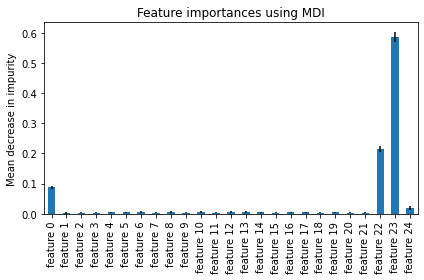

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [f"feature {i}" for i in range(X.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# MLP와 성능 비교

In [ ]:
###mlp without text_embedding###

import math
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
df = pd.read_excel('./drive/MyDrive/skku/인지프/data/test.xlsx')

y = df['TTA']
X = df.drop(['TTA'], axis=1)


sc_cnt = MinMaxScaler()
sc_point = MinMaxScaler()
sc_tta = MinMaxScaler()
sc_len = MinMaxScaler()
sc_nup = MinMaxScaler()
sc_nv = MinMaxScaler()
X['n_uptime'] = sc_cnt.fit_transform(X['n_uptime'].to_numpy().reshape(-1, 1))
X['n_view'] = sc_cnt.fit_transform(X['n_view'].to_numpy().reshape(-1, 1))
X['n_anstime'] = sc_cnt.fit_transform(X['n_anstime'].to_numpy().reshape(-1, 1))
X['Points'] = sc_point.fit_transform(X['Points'].to_numpy().reshape(-1, 1))
y = sc_tta.fit_transform(y.to_numpy().reshape(-1, 1)).reshape(-1)
X['len'] = sc_len.fit_transform(X['len'].to_numpy().reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
"""
x_train = torch.tensor(x_train.to_numpy(), dtype = torch.float32).cuda()
x_test = torch.tensor(x_test.to_numpy(), dtype = torch.float32).cuda()
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).cuda()
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).cuda()
"""
x_train = torch.tensor(x_train.to_numpy(), dtype = torch.float32)
x_test = torch.tensor(x_test.to_numpy(), dtype = torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)
train = TensorDataset(x_train, y_train)
DL_train = DataLoader(train, batch_size=8, shuffle=True)
test = TensorDataset(x_test, y_test)
DL_test = DataLoader(test, batch_size=8, shuffle=False)
class model(torch.nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.l1 = torch.nn.Linear(5, 10)
        self.l2 = torch.nn.Linear(10, 5)
        self.l3 = torch.nn.Linear(5, 1)
    
    def forward(self, x):
        y = self.l1(x)
        y = torch.nn.functional.relu(y)
        y = self.l2(y)
        y = torch.nn.functional.relu(y)
        y = self.l3(y)
        return y

def mse(arr1, arr2):
    arr1-=arr2
    arr1 **= 2
    return math.sqrt(arr1.sum())

md = model()
optim = torch.optim.Adam(md.parameters(), lr = 0.01)
loss_func = torch.nn.MSELoss()
mmm = 0
for epoch in range(0, 10):
  l = 0
  for i , data in enumerate(DL_train):
      md.train()
      x, target = data
      y = md(x)
      loss = torch.sqrt(loss_func(y, target))
      optim.zero_grad()
      loss.backward()
      optim.step()
      y = sc_tta.inverse_transform(y.detach().numpy())
      target = sc_tta.inverse_transform(target.detach().numpy())
      l = np.sqrt(mse(y, target))
  l/=8
  mmm+=l
  print(f'Epoch : {epoch}, batch mean loss : {l}')
y_pred = md(x_test)
u = ((y_test - y_pred)**2).sum()
v = ((y_test - y.mean())**2).sum()
print(1-u/v, mmm/epoch)
print(f'')

In [ ]:
#####mlp with text_embedding####
import math
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

path = './drive/MyDrive/skku/인지프/data/'
###mlp without text_embedding###
df = pd.read_excel(path + 'test.xlsx')

y = df['TTA']
X = df.drop(['TTA'], axis=1)

sc_cnt = MinMaxScaler()
sc_point = MinMaxScaler()
sc_tta = MinMaxScaler()
sc_len = MinMaxScaler()
sc_nup = MinMaxScaler()
sc_nv = MinMaxScaler()
sc_embedding = MinMaxScaler()

X['n_uptime'] = sc_cnt.fit_transform(X['n_uptime'].to_numpy().reshape(-1, 1))
X['n_view'] = sc_cnt.fit_transform(X['n_view'].to_numpy().reshape(-1, 1))
X['n_anstime'] = sc_cnt.fit_transform(X['n_anstime'].to_numpy().reshape(-1, 1))
X['Points'] = sc_point.fit_transform(X['Points'].to_numpy().reshape(-1, 1))
y = sc_tta.fit_transform(y.to_numpy().reshape(-1, 1)).reshape(-1)
X['len'] = sc_len.fit_transform(X['len'].to_numpy().reshape(-1, 1))
for i in range(1,21):
  X[f'embedding{i}'] = sc_embedding.fit_transform(X[f'embedding{i}'].to_numpy().reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
"""
x_train = torch.tensor(x_train.to_numpy(), dtype = torch.float32).cuda()
x_test = torch.tensor(x_test.to_numpy(), dtype = torch.float32).cuda()
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).cuda()
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).cuda()
"""
x_train = torch.tensor(x_train.to_numpy(), dtype = torch.float32)
x_test = torch.tensor(x_test.to_numpy(), dtype = torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

#print(x_train.shape)

y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)
train = TensorDataset(x_train, y_train)
DL_train = DataLoader(train, batch_size=8, shuffle=True)
test = TensorDataset(x_test, y_test)
DL_test = DataLoader(test, batch_size=8, shuffle=False)
class model(torch.nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.l1 = torch.nn.Linear(25, 12)
        self.l2 = torch.nn.Linear(12, 3)
        self.l3 = torch.nn.Linear(3, 1)
    
    def forward(self, x):
        y = self.l1(x)
        y = torch.nn.functional.relu(y)
        y = self.l2(y)
        y = torch.nn.functional.relu(y)
        y = self.l3(y)
        return y

def mse(arr1, arr2):
    arr1-=arr2
    arr1 **= 2
    return math.sqrt(arr1.sum())

md = model()
optim = torch.optim.Adam(md.parameters(), lr = 0.0001)
loss_func = torch.nn.MSELoss()
mmm = 0
for epoch in range(0, 10):
  l = 0
  for i , data in enumerate(DL_train):
      md.train()
      x, target = data
      y = md(x)
      loss = torch.sqrt(loss_func(y, target))
      optim.zero_grad()
      loss.backward()
      optim.step()
      y = sc_tta.inverse_transform(y.detach().numpy())
      target = sc_tta.inverse_transform(target.detach().numpy())
      l = np.sqrt(mse(y, target))
  l/=8
  mmm+=l
  print(f'Epoch : {epoch}, batch mean loss : {l}')
y_pred = md(x_test)
y_pred = sc_tta.inverse_transform(y_pred.detach().numpy())
y_test = sc_tta.inverse_transform(y_test.detach().numpy())
u = ((y_test - y_pred)**2).sum()
v = ((y_test - y_test.mean())**2).sum()
print('coefficient:',1-u/v, 'average_loss:',mmm/epoch)
print(f'')